In [118]:
import pandas as pd
import numpy as np

In [119]:
sequence_data = pd.read_parquet('../data/df.franka_cabinet_drawer_top_open.gzip')

# success_cond = lambda x: x < -0.8 # franka_cabinet_door_left_open termination condition
# success_cond = lambda x: x > -0.01 # franka_cabinet_door_left_close termination condition
# success_cond = lambda x: x > 0.9 # franka_cabinet_door_right_open termination condition
# success_cond = lambda x: x < 0.01 # franka_cabinet_door_right_close termination condition
# success_cond = lambda x: x < 0.01 # franka_cabinet_drawer_top_close termination condition
success_cond = lambda x: x > 0.35 # franka_cabinet_drawer_top_open termination condition

In [120]:
sequence_data

,env_id,timestep,state,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,terminated
0,0.0,0.0,0.000000,-0.236543,2.452464,2.065392,3.826572,1.054470,2.808462,-1.130328,0.066457,0.792702,0.0
1,1.0,0.0,0.000000,-0.680922,0.512250,1.752073,3.923534,0.930152,2.243539,1.054356,2.101578,1.256060,0.0
2,2.0,0.0,0.000000,-1.514688,2.176908,1.865147,6.205402,1.388194,-0.078269,-1.857147,0.072167,-0.290592,0.0
3,3.0,0.0,0.000000,-0.073897,-0.127707,1.102806,4.345099,1.507005,0.844578,-1.430027,2.136870,-1.437259,0.0
4,4.0,0.0,0.000000,-1.681714,1.127030,0.678383,4.319221,1.298825,1.579293,-1.512312,0.948188,-0.132277,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119995,1019.0,4999.0,0.172389,-1.043424,0.480022,-2.047106,-0.489647,1.451385,-0.368412,-0.889287,-1.470420,0.375498,0.0
5119996,1020.0,4999.0,0.324713,0.517358,-0.393594,-1.348105,-1.263676,0.956884,-1.239943,-0.511039,-0.091975,-0.165174,0.0
5119997,1021.0,4999.0,0.326312,0.105287,0.114693,-0.273336,-0.180706,-0.127660,0.292691,-0.260422,1.231082,-0.485798,0.0
5119998,1022.0,4999.0,0.256647,0.655954,0.023486,0.632177,-3.111055,-0.049500,1.604713,-0.123515,2.238791,0.153415,0.0


In [121]:
def split_sequence(dataframe):
    total = 0
    success = 0
    timestep = 0
    sequence_arr = []
    last_row = None
    seq = None
    for _, row in dataframe.iterrows():
        data = np.array([
            timestep,
            row["state"],
            *(row[f"action_{action_idx}"] for action_idx in range(1, 10)) # 9 DOF
        ])
        if seq is None:
            seq = data
        else:
            seq = np.vstack((seq, data))
        
        if last_row is not None and last_row["terminated"] == 1.0 and success_cond(row["state"]):
            success += 1
            sequence_arr.append(seq)
            seq = None

        if last_row is not None and last_row["terminated"] == 1.0 and not success_cond(row["state"]):
            seq = None

        timestep += 1

        if row["terminated"] == 1.0:
            total += 1
            timestep = 0

        last_row = row

    return sequence_arr, total, success

In [122]:
max_envs = sequence_data["env_id"].max() + 1
sequence_arr = []
total = 0
success = 0
for env_id in range(int(max_envs)):
    cond = sequence_data["env_id"] == float(env_id)
    env_sequence_arr, env_total, env_success = split_sequence(sequence_data[cond])

    success += env_success
    total += env_total
    sequence_arr.extend(env_sequence_arr)

In [123]:
print(success / total * 100)
print(len(sequence_arr))

11.426372992209291
1188


In [124]:
# since 500 is the max episode length
timestep = np.arange(500).reshape(500, )

for sequence in sequence_arr:
    sequence.resize((500, 11), refcheck=False)
    sequence[:, 0] = timestep

In [125]:
sequence_arr[10][1]

array([ 1.        ,  0.        , -0.16608137, -1.49102283, -0.92730206,
        2.92148352,  1.5929265 ,  3.18616629, -1.85078907, -0.9854455 ,
       -0.27748138])

In [126]:
graph_dataframe = pd.DataFrame(sequence_arr[0], columns=["timestamp", "state", "dof_1", "dof_2", "dof_3", "dof_4", "dof_5", "dof_6", "dof_7", "dof_8", "dof_9"])
graph_dataframe

,timestamp,state,dof_1,dof_2,dof_3,dof_4,dof_5,dof_6,dof_7,dof_8,dof_9
0,0.0,0.0,-0.193533,2.269884,1.212985,4.392726,-0.643024,4.190668,-0.423312,-1.711435,-0.567313
1,1.0,0.0,0.673164,1.632480,-0.546982,3.664651,0.049065,3.171655,-0.210893,-0.775370,-0.788062
2,2.0,0.0,-0.786853,0.465032,-1.301901,3.286432,0.378730,0.827758,-0.933571,-0.700239,-0.695518
3,3.0,0.0,-1.290767,1.319565,1.059340,3.172382,-0.028655,2.915845,-1.017001,-1.455129,0.672267
4,4.0,0.0,-1.187907,1.544596,-1.288295,3.483059,-0.001179,3.430081,-0.587397,0.078329,-0.443991
...,...,...,...,...,...,...,...,...,...,...,...
495,495.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,496.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
497,497.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
498,498.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


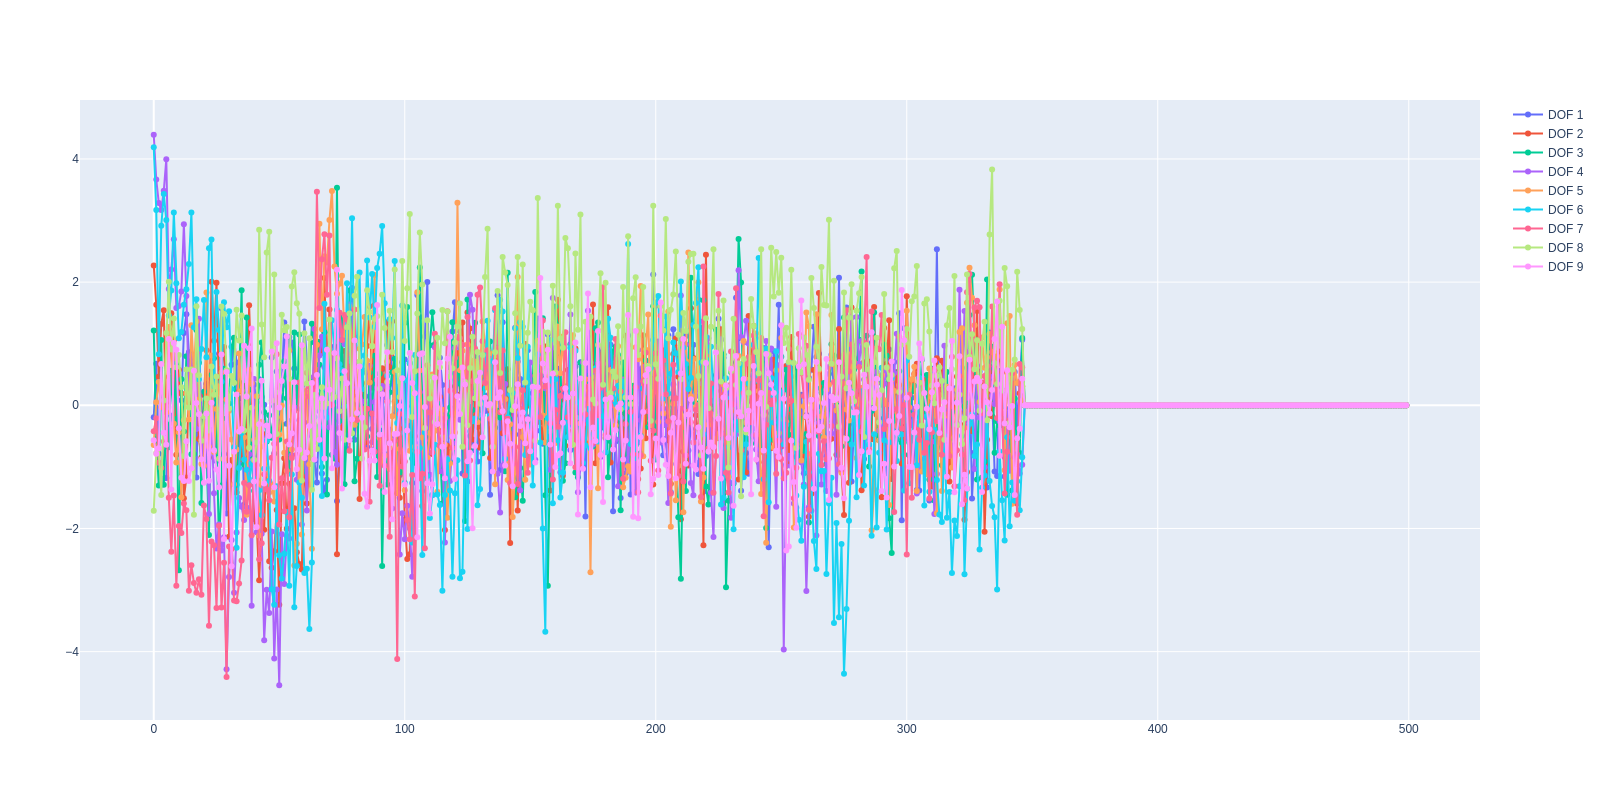

In [127]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
for dof_idx in range(1, 10):
    fig.add_trace(go.Scatter(x=graph_dataframe["timestamp"], y=graph_dataframe[f"dof_{dof_idx}"],
                        mode='lines+markers',
                        name=f'DOF {dof_idx}'))
fig.update_layout(
    autosize=True,
    height=800,
)
fig.show()

In [128]:
sequence_np = np.vstack(sequence_arr).reshape(-1, 500, 11)

In [129]:
# np.save('../data/sequence/franka_cabinet_door_right_close.npy', sequence_np)